# TESS Atlas fit for TOI 519

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 519.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-519.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-519.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-519.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 519

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 519 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

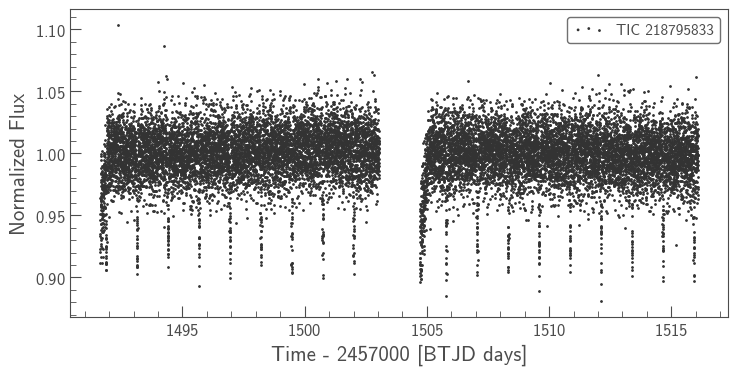

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -77030.44748814996 -> -76897.64118597943


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -75245.41399832543 -> -75022.6430839117


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -75022.6430839117 -> -73039.24553532965


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -73039.24553532965 -> -73038.4249651638


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -73038.4249651638 -> -73038.32446422361


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -73038.32446422361 -> -73037.67593471684


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -73037.67593471684 -> -72944.68381874009


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -72944.68381874009 -> -72944.68381873978


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -72944.68381873978 -> -72944.68381873978


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -72944.68381873978 -> -72944.68381873978


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -72944.68381873978 -> -72944.68381873978


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -72944.68381873978 -> -72944.68381873978


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -72944.68381873978 -> -72944.68381873978


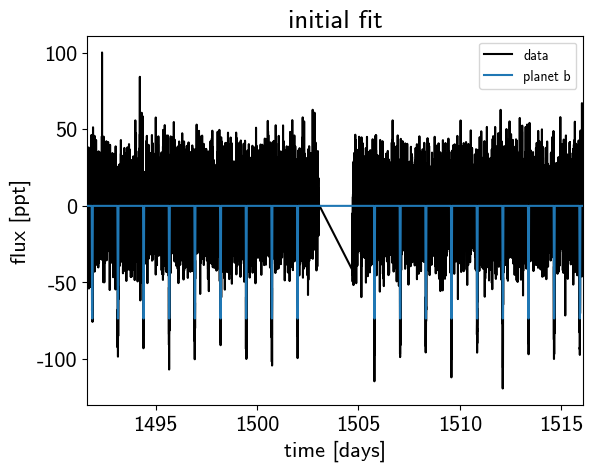

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:04, 22.37draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:18,  5.05draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:17,  5.32draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:29,  3.13draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:28,  3.18draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:28,  3.11draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:26,  3.26draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:32,  2.64draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:26,  3.27draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:33,  2.48draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:26,  3.11draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:36,  2.26draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:31,  2.60draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:30,  2.65draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:35,  2.20draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:27,  2.86draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:31,  2.45draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:30,  2.45draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:26,  2.78draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:33,  2.18draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:31,  2.28draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:29,  2.37draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:24,  2.82draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:29,  2.32draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:25,  2.66draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:30,  2.19draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:27,  2.32draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:22,  2.86draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:20,  3.05draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:19,  3.14draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:23,  2.49draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:19,  2.96draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:24,  2.31draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:20,  2.67draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:21,  2.58draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:16<00:18,  2.90draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:15,  3.33draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:19,  2.65draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:14,  3.38draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:17<00:19,  2.53draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:17,  2.67draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:14,  3.14draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:15,  2.84draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:19<00:15,  2.87draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:19<00:14,  2.98draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:17,  2.43draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:20<00:13,  3.03draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:16,  2.39draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:12,  3.03draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:16,  2.36draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:13,  2.77draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:15,  2.25draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:22<00:13,  2.58draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:23<00:15,  2.26draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:23<00:12,  2.57draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:13,  2.39draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:24<00:13,  2.37draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:24<00:12,  2.44draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:25<00:12,  2.27draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:25<00:09,  2.92draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:26<00:11,  2.28draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:26<00:08,  2.93draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:26<00:10,  2.44draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:26<00:08,  2.76draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:27<00:08,  2.75draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:27<00:09,  2.31draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:28<00:07,  2.52draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:28<00:06,  2.90draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:29<00:07,  2.29draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:29<00:05,  2.92draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:30<00:07,  2.12draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:31<00:06,  2.23draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:31<00:04,  2.88draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:31<00:04,  2.66draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:32<00:03,  2.79draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:32<00:02,  3.02draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:32<00:03,  2.58draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:33<00:03,  1.86draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:34<00:04,  1.40draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:35<00:03,  1.48draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:35<00:02,  1.75draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:36<00:01,  1.61draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:37<00:01,  1.49draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:38<00:00,  1.27draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:41<00:00,  1.50s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:08, 11.53draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.48draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:23,  3.88draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:29,  3.07draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:27,  3.25draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:35,  2.48draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:33,  2.60draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:28,  2.97draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:30,  2.78draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:33,  2.46draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:26,  3.15draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:32,  2.47draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:24,  3.24draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:29,  2.67draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:32,  2.36draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:25,  2.95draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:37,  2.00draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:34,  2.08draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:29,  2.43draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:27,  2.53draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:33,  2.09draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:29,  2.24draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:23,  2.85draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:27,  2.39draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:22,  2.85draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:20,  3.00draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:12<00:19,  3.10draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:22,  2.61draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:20,  2.81draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:21,  2.69draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:23,  2.38draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:20,  2.72draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:16,  3.20draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:20,  2.65draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:15<00:15,  3.33draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:20,  2.52draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:15,  3.16draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:14,  3.34draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:15,  3.08draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:17<00:14,  3.17draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:18,  2.40draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:16,  2.62draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:15,  2.79draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:19<00:14,  2.80draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:14,  2.72draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:20<00:12,  3.02draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:20<00:11,  3.32draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:13,  2.67draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:21<00:09,  3.51draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:22<00:12,  2.55draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:22<00:11,  2.64draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:22<00:08,  3.35draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:23<00:10,  2.73draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:23<00:11,  2.37draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:24<00:10,  2.49draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:09,  2.59draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:07,  3.11draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:26<00:06,  3.09draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:26<00:06,  3.05draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:27<00:05,  3.10draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:27<00:04,  3.63draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:27<00:04,  3.09draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:27<00:03,  3.52draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:04,  2.81draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:29<00:03,  2.85draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:29<00:03,  3.14draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:30<00:04,  2.08draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:31<00:04,  1.68draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:31<00:04,  1.62draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:32<00:03,  1.94draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:02,  2.04draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:33<00:02,  1.79draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:34<00:01,  1.93draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.70draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  1.34s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:55,  1.76draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:23,  2.40draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:05,  3.06draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:12,  2.74draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<00:57,  3.47draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:06,  2.95draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:55,  3.53draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:03,  3.09draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:54,  3.55draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:59,  3.23draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:03<00:57,  3.37draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:55,  3.42draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<01:00,  3.15draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:04<00:52,  3.62draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:04<01:01,  3.06draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:50,  3.72draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:05<00:59,  3.13draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:05<00:51,  3.62draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<00:51,  3.56draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:06<00:47,  3.85draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:47,  3.75draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:07<00:49,  3.60draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:07<00:47,  3.76draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<00:51,  3.40draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:07<00:45,  3.88draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:08<00:51,  3.35draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:08<00:45,  3.79draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:52,  3.25draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:45,  3.78draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:09<00:50,  3.34draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:09<00:52,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:09<00:49,  3.37draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:10<00:40,  4.15draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:10<00:42,  3.87draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:10<00:34,  4.72draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:10<00:40,  4.08draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:10<00:36,  4.44draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:11<00:40,  4.00draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:39,  4.06draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:11<00:49,  3.26draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:12<00:41,  3.84draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:12<00:49,  3.17draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:12<00:44,  3.55draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:12<00:40,  3.88draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:13<00:47,  3.23draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:13<00:45,  3.38draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:13<00:38,  3.99draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:13<00:33,  4.51draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:14<00:42,  3.51draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:14<00:36,  4.11draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:14<00:43,  3.42draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:15<00:37,  3.95draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:15<00:41,  3.54draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:15<00:38,  3.75draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:15<00:32,  4.52draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:16<00:33,  4.33draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:16<00:38,  3.74draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:16<00:36,  3.84draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:16<00:39,  3.56draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:17<00:36,  3.86draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:17<00:30,  4.57draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:17<00:34,  4.00draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:18<00:33,  4.02draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:18<00:37,  3.62draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:18<00:35,  3.79draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:18<00:38,  3.44draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:19<00:35,  3.74draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:19<00:29,  4.47draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:19<00:31,  4.08draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:19<00:33,  3.90draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:20<00:35,  3.59draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:20<00:33,  3.84draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:20<00:36,  3.44draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:20<00:34,  3.61draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:21<00:37,  3.26draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:21<00:34,  3.52draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:21<00:36,  3.32draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:22<00:33,  3.60draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:22<00:35,  3.38draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:22<00:33,  3.59draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:23<00:35,  3.37draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:23<00:31,  3.68draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:23<00:34,  3.36draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:23<00:32,  3.54draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:24<00:33,  3.44draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:24<00:28,  4.00draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:24<00:33,  3.31draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:24<00:29,  3.80draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:25<00:34,  3.20draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:25<00:30,  3.63draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:25<00:33,  3.24draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:26<00:31,  3.41draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:27<00:30,  3.38draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:27<00:24,  4.20draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:27<00:27,  3.68draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:27<00:25,  3.94draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:28<00:33,  2.99draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:29<00:32,  2.97draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:29<00:31,  3.03draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:30<00:28,  3.31draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:30<00:24,  3.70draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:30<00:28,  3.21draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:30<00:24,  3.60draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:31<00:27,  3.30draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:31<00:23,  3.68draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:31<00:27,  3.19draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:32<00:23,  3.63draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:32<00:27,  3.14draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:32<00:23,  3.56draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:33<00:25,  3.21draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:33<00:26,  3.14draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:33<00:24,  3.37draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:34<00:25,  3.16draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:34<00:21,  3.62draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:34<00:24,  3.20draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:34<00:20,  3.77draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:35<00:23,  3.21draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:35<00:17,  4.19draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:35<00:23,  3.10draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:36<00:22,  3.21draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:36<00:20,  3.32draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:37<00:18,  3.60draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:37<00:15,  4.27draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:37<00:18,  3.48draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:38<00:15,  4.03draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:38<00:14,  4.35draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:38<00:17,  3.60draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:38<00:15,  4.06draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:39<00:12,  4.62draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:39<00:13,  4.23draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:39<00:14,  3.99draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:39<00:15,  3.72draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:40<00:16,  3.44draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:40<00:14,  3.70draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:40<00:14,  3.66draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:40<00:11,  4.45draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:41<00:15,  3.44draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:41<00:12,  4.20draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:41<00:13,  3.65draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:41<00:12,  4.03draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:42<00:13,  3.59draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:42<00:11,  3.99draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:42<00:10,  4.37draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:43<00:11,  4.00draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:43<00:10,  3.87draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:43<00:08,  4.73draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:44<00:08,  4.48draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:44<00:08,  4.38draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:44<00:11,  3.28draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:44<00:09,  4.00draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:45<00:12,  2.83draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:46<00:11,  2.98draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:46<00:09,  3.36draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:46<00:09,  3.30draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:47<00:08,  3.36draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:47<00:08,  3.40draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:48<00:06,  4.00draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:48<00:06,  3.80draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:48<00:06,  3.84draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:48<00:06,  3.62draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:49<00:06,  3.30draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:49<00:05,  3.66draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:49<00:04,  4.30draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:49<00:04,  4.16draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:50<00:04,  3.81draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:50<00:04,  3.78draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:50<00:04,  3.81draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:51<00:03,  3.76draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:51<00:03,  3.82draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:51<00:03,  3.76draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:51<00:03,  3.81draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:52<00:02,  3.74draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:52<00:02,  3.81draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:52<00:02,  3.74draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:52<00:02,  3.81draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:53<00:01,  3.61draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:53<00:01,  3.81draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:53<00:01,  3.02draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:54<00:00,  3.07draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:55<00:00,  3.18draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:56<00:00,  1.42draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:07, 52.17draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:08, 46.66draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:00<00:08, 44.28draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:00<00:10, 36.51draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:00<00:12, 30.52draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:13, 27.80draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:00<00:11, 32.06draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:00<00:11, 33.22draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:01<00:12, 30.14draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:01<00:13, 26.16draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:14, 24.65draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:01<00:14, 24.40draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:01<00:12, 27.35draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:01<00:11, 31.33draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:02<00:16, 20.76draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:02<00:20, 16.63draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:02<00:22, 14.82draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:02<00:19, 16.60draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:03<00:17, 19.23draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:03<00:16, 20.11draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:03<00:15, 21.23draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:03<00:12, 25.08draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:03<00:12, 24.52draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:03<00:13, 23.45draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:03<00:13, 22.79draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:03<00:11, 25.78draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:04<00:10, 29.67draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:04<00:10, 28.88draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:04<00:09, 31.36draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:04<00:08, 32.62draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:04<00:09, 30.19draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:04<00:09, 30.24draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:04<00:09, 28.57draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:05<00:08, 32.53draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:05<00:08, 32.84draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:05<00:07, 36.16draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:05<00:10, 25.40draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:05<00:10, 24.47draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:05<00:11, 22.55draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:05<00:10, 24.07draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:06<00:09, 26.66draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:06<00:08, 28.44draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:06<00:08, 28.06draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:06<00:08, 28.28draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:06<00:08, 28.12draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:06<00:07, 28.69draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:06<00:09, 24.55draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:06<00:08, 24.75draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:07<00:07, 28.86draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:07<00:06, 30.65draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:07<00:07, 26.77draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:07<00:07, 26.14draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:07<00:09, 20.82draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:07<00:10, 18.42draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:08<00:09, 20.30draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:08<00:08, 23.33draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:08<00:06, 26.81draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:08<00:06, 28.82draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:08<00:04, 34.60draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:08<00:04, 36.75draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:08<00:04, 39.71draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:08<00:03, 40.00draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:08<00:03, 44.48draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:09<00:03, 41.01draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:09<00:03, 38.60draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:09<00:03, 34.79draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:09<00:04, 32.42draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:09<00:04, 30.94draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:09<00:03, 34.92draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:09<00:03, 37.77draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:10<00:02, 39.88draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:10<00:02, 37.40draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:10<00:03, 30.97draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:10<00:02, 34.96draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:10<00:03, 27.17draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:10<00:03, 27.28draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:11<00:03, 27.09draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:11<00:02, 31.30draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:11<00:01, 36.42draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:11<00:01, 37.96draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:11<00:01, 36.78draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:11<00:01, 30.72draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:11<00:01, 31.92draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:11<00:01, 34.89draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:12<00:01, 39.03draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:12<00:01, 36.33draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:12<00:00, 39.26draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:12<00:00, 37.95draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:12<00:00, 34.26draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:12<00:00, 34.93draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:12<00:00, 31.17draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:13<00:00, 26.39draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:13<00:00, 19.20draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:13<00:00, 20.81draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:13<00:00, 29.67draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:17, 44.50draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:17, 44.55draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:20, 38.58draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:22, 35.38draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:22, 34.23draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:00<00:22, 35.13draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:00<00:19, 40.11draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:00<00:19, 39.22draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:01<00:21, 36.07draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:21, 35.33draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:01<00:19, 37.93draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:01<00:19, 39.16draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:01<00:19, 38.34draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:01<00:18, 38.92draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:01<00:19, 37.84draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:02<00:22, 32.05draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:02<00:22, 32.84draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:02<00:23, 30.91draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:02<00:24, 29.63draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:02<00:23, 30.75draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:02<00:21, 32.49draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:02<00:18, 37.02draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:02<00:18, 38.48draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:03<00:20, 33.81draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:03<00:19, 34.40draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:03<00:19, 35.17draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:03<00:19, 35.65draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:03<00:18, 36.13draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:03<00:18, 36.38draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:03<00:17, 38.26draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:03<00:20, 31.93draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:04<00:20, 32.06draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:04<00:19, 33.47draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:04<00:18, 35.99draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:04<00:17, 37.07draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:04<00:17, 37.28draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:04<00:15, 40.10draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:04<00:14, 42.35draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:04<00:14, 43.05draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:04<00:15, 41.02draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:05<00:15, 40.94draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:05<00:14, 41.28draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:05<00:13, 43.37draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:05<00:12, 47.04draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:05<00:14, 41.61draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:05<00:14, 40.03draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:05<00:16, 36.42draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:06<00:14, 39.06draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:06<00:13, 41.59draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:06<00:12, 46.79draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:06<00:13, 40.73draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:06<00:14, 39.22draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:06<00:13, 42.28draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:06<00:12, 43.76draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:06<00:13, 39.71draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:07<00:13, 38.68draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:07<00:13, 38.08draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:07<00:13, 39.77draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:07<00:11, 43.89draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:07<00:10, 49.30draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:07<00:10, 46.16draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:07<00:11, 42.97draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:07<00:11, 42.29draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:08<00:11, 42.16draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:08<00:11, 43.78draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:08<00:12, 39.73draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:08<00:11, 39.78draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:08<00:11, 42.09draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:08<00:10, 46.18draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:08<00:11, 40.34draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:08<00:10, 42.18draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:09<00:10, 44.00draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:09<00:10, 43.06draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:09<00:10, 42.10draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:09<00:11, 37.84draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:09<00:13, 32.08draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:09<00:13, 30.63draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:09<00:14, 28.39draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:09<00:13, 30.72draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:10<00:12, 32.09draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:10<00:12, 33.11draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:10<00:12, 32.64draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:10<00:11, 34.89draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:10<00:11, 34.89draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:10<00:10, 36.95draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:10<00:10, 36.83draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:10<00:10, 36.76draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:11<00:09, 39.23draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:11<00:09, 38.18draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:11<00:09, 39.88draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:11<00:09, 39.05draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:11<00:08, 42.56draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:11<00:07, 45.26draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:11<00:07, 43.71draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:12<00:08, 40.04draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:12<00:08, 38.94draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:12<00:08, 40.14draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:12<00:07, 42.85draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:12<00:06, 45.00draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:12<00:06, 44.52draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:12<00:08, 37.49draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:12<00:07, 40.43draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:13<00:07, 41.16draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:13<00:06, 46.33draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:13<00:05, 49.27draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:13<00:05, 53.52draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:13<00:05, 48.95draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:13<00:06, 39.74draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:13<00:07, 35.33draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:14<00:07, 33.56draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:14<00:07, 34.49draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:14<00:06, 35.77draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:14<00:06, 36.19draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:14<00:06, 35.57draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:14<00:07, 30.55draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:14<00:06, 32.70draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:14<00:06, 35.57draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:15<00:05, 37.31draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:15<00:05, 39.42draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:15<00:05, 39.03draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:15<00:05, 36.56draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:15<00:05, 39.26draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:15<00:05, 38.57draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:15<00:04, 40.06draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:15<00:04, 40.73draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:16<00:04, 42.97draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:16<00:03, 43.13draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:16<00:03, 44.71draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:16<00:03, 47.41draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:16<00:03, 46.39draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:16<00:03, 39.20draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:16<00:04, 32.56draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:16<00:04, 32.79draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:17<00:04, 29.81draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:17<00:03, 34.68draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:17<00:03, 36.00draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:17<00:03, 38.89draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:17<00:02, 41.21draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:17<00:02, 38.10draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:17<00:02, 39.52draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:18<00:02, 40.93draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:18<00:02, 31.68draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:18<00:03, 29.48draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:18<00:03, 26.57draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:18<00:02, 29.05draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:18<00:02, 31.80draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:18<00:02, 35.39draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:19<00:01, 33.74draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:19<00:01, 33.86draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:19<00:01, 34.47draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:19<00:01, 35.40draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:19<00:01, 36.62draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:19<00:01, 39.06draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:19<00:01, 32.53draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:20<00:01, 28.47draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:20<00:01, 22.77draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:20<00:01, 23.93draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:20<00:00, 25.85draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:20<00:00, 26.55draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:20<00:00, 27.02draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:20<00:00, 24.85draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:21<00:00, 25.58draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:21<00:00, 26.29draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:21<00:00, 25.78draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:21<00:00, 26.50draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:21<00:00, 25.99draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<02:04, 35.47draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<01:57, 37.30draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<05:26, 13.47draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:01<07:45,  9.44draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:01<08:13,  8.89draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<06:30, 11.22draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:41, 12.84draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<04:47, 15.21draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<05:00, 14.58draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:02<05:07, 14.24draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:02<04:48, 15.14draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:02<04:04, 17.85draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<03:39, 19.93draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<03:01, 24.01draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:02<02:39, 27.38draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:02<02:29, 29.19draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<02:20, 31.03draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:03<02:48, 25.73draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:03<02:25, 29.84draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:03<02:08, 33.59draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:03<02:38, 27.35draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:03<02:27, 29.39draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:03<02:17, 31.35draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:04<02:39, 27.00draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:04<02:51, 25.18draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:04<02:45, 25.99draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:04<02:40, 26.82draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:04<02:43, 26.31draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:04<02:39, 26.91draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:04<02:20, 30.49draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:04<02:17, 31.15draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:04<02:09, 33.20draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:05<01:58, 36.04draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<01:51, 38.48draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:05<01:46, 40.18draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:05<01:48, 39.49draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:05<01:38, 43.16draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:05<01:37, 43.86draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:05<01:51, 37.98draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:05<01:53, 37.55draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:06<01:50, 38.21draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:06<01:43, 40.74draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:06<01:38, 42.76draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:06<01:53, 37.21draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:06<01:55, 36.44draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:06<01:46, 39.66draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:06<01:43, 40.54draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:06<01:51, 37.86draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:07<01:40, 41.63draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:07<01:49, 38.34draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:07<02:16, 30.73draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:07<02:07, 32.75draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:07<02:18, 30.25draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:07<02:09, 32.21draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:07<02:07, 32.79draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:08<02:08, 32.51draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:08<01:58, 35.09draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:08<01:57, 35.34draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:08<01:48, 38.31draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:08<01:48, 38.35draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:08<01:37, 42.44draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:08<02:01, 34.04draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:08<01:57, 35.12draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:09<02:00, 34.36draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:09<01:49, 37.58draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:09<01:58, 34.76draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:09<01:59, 34.35draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:09<01:47, 38.34draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:09<01:50, 37.32draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:09<02:04, 33.01draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:10<03:00, 22.77draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:10<03:27, 19.78draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:10<03:44, 18.20draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:10<04:00, 16.97draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:10<03:33, 19.11draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:11<03:07, 21.76draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:11<03:12, 21.16draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:11<02:45, 24.60draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:11<02:29, 27.18draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:11<02:21, 28.80draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:11<02:15, 29.95draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:11<02:09, 31.43draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:11<02:16, 29.66draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:12<02:06, 32.01draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:12<01:55, 35.04draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:12<01:38, 41.07draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:12<01:43, 38.90draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:12<01:48, 37.07draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:12<01:45, 38.02draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:12<01:59, 33.71draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:12<01:47, 37.34draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:13<01:36, 41.41draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:13<01:40, 40.02draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:13<01:34, 42.09draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:13<01:35, 41.82draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:13<01:36, 41.18draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:13<01:33, 42.71draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:13<01:38, 40.19draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:13<01:31, 43.55draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:14<01:57, 33.65draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:14<02:11, 30.12draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:14<02:10, 30.39draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:14<02:12, 29.87draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:14<01:53, 34.70draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:14<01:45, 37.54draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:14<01:46, 37.10draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:15<01:51, 35.42draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:15<01:49, 35.75draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:15<01:37, 40.08draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:15<01:33, 41.87draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:15<01:35, 40.81draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:15<01:44, 37.36draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:15<01:53, 34.29draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:15<01:49, 35.64draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:16<01:58, 32.97draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:16<01:48, 35.93draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:16<01:39, 39.14draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:16<01:44, 37.22draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:16<01:34, 41.12draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:16<01:30, 42.83draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:16<01:23, 46.26draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:16<01:17, 49.70draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:17<01:15, 51.34draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:17<01:32, 41.53draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:17<01:40, 38.37draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:17<01:42, 37.58draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:17<01:55, 33.05draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:17<01:51, 34.32draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:17<01:48, 35.17draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:18<02:01, 31.44draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:18<02:07, 29.95draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:18<01:51, 34.28draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:18<02:01, 31.31draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:18<02:21, 26.86draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:18<02:07, 29.68draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:18<01:52, 33.67draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:19<01:48, 35.05draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:19<01:39, 37.82draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:19<01:33, 40.40draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:19<01:33, 40.34draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:19<01:40, 37.62draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:19<01:35, 39.48draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:19<01:45, 35.46draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:19<01:52, 33.29draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:20<01:57, 31.80draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:20<01:53, 33.00draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:20<01:50, 33.93draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:20<01:41, 36.64draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:20<01:47, 34.74draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:20<01:48, 34.18draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:20<01:39, 37.22draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:20<01:38, 37.66draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:21<01:44, 35.36draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:21<01:41, 36.49draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:21<01:39, 37.11draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:21<01:38, 37.64draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:21<01:37, 38.03draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:21<01:31, 40.47draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:21<01:27, 42.00draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:21<01:21, 45.29draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:21<01:15, 48.47draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:22<01:17, 47.45draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:22<01:16, 47.68draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:22<01:16, 47.77draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:22<01:16, 48.01draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:22<01:16, 47.93draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:22<01:15, 48.05draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:22<01:11, 50.75draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:22<01:08, 52.80draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:22<01:12, 49.70draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:23<01:04, 55.64draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:23<01:07, 53.84draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:23<01:18, 45.74draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:23<01:24, 42.46draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:23<01:28, 40.60draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:23<01:23, 42.74draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:23<01:21, 43.81draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:23<01:27, 40.77draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:24<01:27, 40.86draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:24<01:33, 38.35draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:24<01:37, 36.71draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:24<01:27, 40.64draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:24<01:28, 40.14draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:24<01:24, 42.01draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:24<01:18, 45.07draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:24<01:17, 45.78draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:25<01:16, 46.11draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:25<01:20, 43.54draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:25<01:19, 44.18draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [00:25<01:20, 43.87draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:25<01:15, 46.55draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:25<01:10, 49.51draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:25<01:13, 47.90draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:25<01:06, 52.85draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:25<01:04, 53.82draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:26<01:07, 51.77draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:26<01:15, 46.06draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:26<01:15, 45.79draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:26<01:15, 46.07draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:26<01:20, 43.20draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:26<01:28, 39.09draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:26<01:39, 34.80draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:27<01:45, 32.60draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:27<01:37, 35.15draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:27<01:23, 40.95draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:27<01:32, 37.22draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:27<01:56, 29.36draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:27<02:00, 28.27draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:28<02:14, 25.28draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:28<02:09, 26.41draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:28<02:00, 28.27draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:28<01:54, 29.77draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:28<01:39, 34.01draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:28<01:39, 33.97draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:28<01:43, 32.77draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:28<01:45, 32.19draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [00:29<01:36, 34.86draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:29<01:28, 37.92draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:29<01:23, 40.49draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:29<01:22, 40.55draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:29<01:22, 40.87draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [00:29<01:12, 46.39draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:29<01:17, 43.30draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:29<01:22, 40.27draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:30<01:19, 42.03draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:30<01:25, 39.11draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [00:30<01:17, 42.71draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:30<01:17, 43.04draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:30<01:15, 43.99draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:30<01:23, 39.50draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:30<01:20, 41.01draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:30<01:21, 40.66draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:31<01:19, 41.55draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [00:31<01:20, 41.01draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:31<01:16, 42.87draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [00:31<01:13, 44.30draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:31<01:29, 36.41draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [00:31<01:28, 37.09draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:31<01:51, 29.28draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:32<01:52, 29.07draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [00:32<01:43, 31.40draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:32<01:37, 33.43draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:32<01:28, 36.70draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [00:32<01:27, 37.14draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:32<01:19, 40.91draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:32<01:19, 40.45draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [00:32<01:17, 41.86draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:32<01:16, 42.31draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:33<01:15, 42.76draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:33<01:23, 38.42draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [00:33<01:19, 40.40draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [00:33<01:12, 44.15draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:33<01:12, 44.04draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:33<01:08, 46.59draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [00:33<01:02, 50.84draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:33<01:01, 51.98draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [00:34<01:13, 42.83draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [00:34<01:18, 40.13draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [00:34<01:19, 39.74draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:34<01:17, 40.84draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:34<01:15, 41.49draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:34<01:09, 45.09draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [00:34<01:08, 45.84draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [00:34<01:12, 43.41draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:35<01:11, 43.57draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:35<01:11, 43.84draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:35<01:06, 46.85draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:35<01:08, 45.73draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:35<01:12, 42.97draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:35<01:09, 44.34draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [00:35<01:14, 41.28draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:35<01:12, 42.47draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [00:36<01:08, 44.92draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:36<01:08, 44.64draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:36<01:09, 44.01draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [00:36<01:13, 41.70draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [00:36<01:08, 44.83draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:36<01:06, 45.82draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:36<01:24, 36.24draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:36<01:18, 38.98draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:37<01:19, 38.13draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [00:37<01:14, 40.93draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:37<01:14, 40.70draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:37<01:18, 38.57draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:37<01:18, 38.36draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [00:37<01:18, 38.22draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [00:37<01:18, 38.60draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:37<01:13, 40.96draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:37<01:11, 41.87draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:38<01:22, 36.43draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:38<01:20, 37.29draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:38<01:11, 41.89draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [00:38<01:09, 42.86draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:38<01:10, 42.03draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [00:38<01:07, 44.35draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [00:38<01:01, 47.92draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [00:38<00:55, 53.46draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [00:39<01:05, 45.12draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [00:39<01:20, 36.45draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [00:39<01:36, 30.42draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [00:39<01:42, 28.81draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [00:39<01:57, 25.04draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [00:40<02:06, 23.11draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [00:40<01:57, 24.85draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [00:40<01:45, 27.72draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [00:40<01:42, 28.58draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:40<01:40, 29.04draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:40<01:28, 32.84draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [00:40<01:22, 35.18draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:40<01:23, 34.82draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [00:41<01:29, 32.38draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:41<01:25, 33.87draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [00:41<01:22, 34.96draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:41<01:24, 34.06draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [00:41<01:28, 32.48draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [00:41<01:28, 32.35draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [00:41<01:32, 31.00draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [00:41<01:37, 29.34draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [00:42<01:26, 33.20draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [00:42<01:22, 34.63draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:42<01:12, 39.13draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:42<01:09, 41.08draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:42<01:08, 41.41draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:42<01:06, 42.57draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [00:42<01:05, 43.24draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [00:42<01:03, 44.61draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [00:42<01:02, 45.18draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [00:43<01:05, 43.07draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [00:43<01:00, 46.49draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [00:43<01:03, 43.96draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [00:43<01:10, 39.54draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [00:43<01:11, 39.26draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [00:43<01:06, 41.86draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:43<01:10, 39.50draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [00:43<01:07, 41.30draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [00:44<01:08, 40.72draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [00:44<01:06, 41.95draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [00:44<01:07, 41.08draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:44<01:05, 42.23draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:44<01:08, 40.00draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [00:44<01:06, 41.37draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [00:44<01:07, 40.78draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:44<01:05, 42.13draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [00:45<01:08, 40.06draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [00:45<01:09, 39.46draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [00:45<01:02, 43.54draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [00:45<01:02, 43.57draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:45<00:59, 45.50draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [00:45<01:00, 44.50draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [00:45<00:59, 45.46draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [00:45<01:03, 42.24draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [00:46<01:09, 38.50draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [00:46<01:20, 33.27draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [00:46<01:24, 31.98draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:46<01:25, 31.23draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [00:46<01:36, 27.82draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:46<01:31, 29.29draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [00:46<01:20, 33.18draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [00:47<01:14, 35.86draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [00:47<01:08, 38.97draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [00:47<01:04, 40.90draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [00:47<01:02, 42.24draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [00:47<00:58, 45.30draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [00:47<00:58, 45.28draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [00:47<00:57, 45.98draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [00:47<00:57, 45.64draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [00:47<00:55, 47.51draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [00:48<00:56, 46.65draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [00:48<00:56, 46.44draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [00:48<00:55, 46.89draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [00:48<00:57, 45.40draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [00:48<00:56, 46.31draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [00:48<01:01, 42.07draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [00:48<01:06, 38.64draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [00:48<01:05, 39.57draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [00:49<01:10, 36.64draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [00:49<01:07, 38.26draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [00:49<01:02, 41.26draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [00:49<01:02, 40.63draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [00:49<01:08, 37.32draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [00:49<01:11, 35.72draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [00:49<01:14, 34.30draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [00:49<01:05, 38.81draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [00:50<01:05, 38.98draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [00:50<01:00, 41.60draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [00:50<00:57, 43.60draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [00:50<00:55, 45.24draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [00:50<00:51, 48.50draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [00:50<00:49, 50.12draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [00:50<00:59, 41.89draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [00:50<00:53, 46.63draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [00:51<00:54, 46.05draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [00:51<01:08, 36.39draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [00:51<01:04, 38.25draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [00:51<01:03, 38.69draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [00:51<01:05, 37.67draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [00:51<01:06, 37.01draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [00:51<01:01, 39.91draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [00:51<00:57, 42.41draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [00:52<00:54, 44.72draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [00:52<00:53, 45.55draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [00:52<00:57, 42.38draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [00:52<00:56, 42.74draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [00:52<00:53, 45.53draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [00:52<00:51, 47.28draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [00:52<00:48, 49.84draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [00:52<00:45, 52.50draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [00:53<00:44, 53.65draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [00:53<00:43, 54.39draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [00:53<00:48, 49.52draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [00:53<00:45, 51.97draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [00:53<00:45, 51.98draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [00:53<00:42, 55.89draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [00:53<00:40, 58.45draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [00:53<00:56, 41.79draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [00:54<01:03, 36.83draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [00:54<01:00, 38.65draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [00:54<00:54, 42.51draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [00:54<01:02, 37.23draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [00:54<01:00, 38.30draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [00:54<01:00, 38.60draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [00:54<01:00, 38.42draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [00:55<00:59, 38.55draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [00:55<01:00, 38.36draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [00:55<00:59, 38.42draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [00:55<01:00, 37.84draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [00:55<00:54, 41.81draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [00:55<00:57, 39.47draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [00:55<01:02, 36.78draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [00:55<01:05, 34.98draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [00:56<01:00, 37.79draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [00:56<00:55, 40.62draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [00:56<00:53, 42.38draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [00:56<00:51, 43.67draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [00:56<00:52, 43.03draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [00:56<00:54, 41.61draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [00:56<00:49, 45.70draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [00:56<00:51, 43.50draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [00:56<00:47, 47.15draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [00:57<00:47, 47.30draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [00:57<00:47, 47.05draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [00:57<00:47, 46.35draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [00:57<00:43, 50.60draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [00:57<00:46, 47.52draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [00:57<00:47, 46.45draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [00:57<00:48, 44.84draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [00:57<00:48, 44.63draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [00:58<00:59, 36.95draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [00:58<00:59, 36.74draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [00:58<00:57, 37.55draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [00:58<01:00, 35.56draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [00:58<00:58, 36.99draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [00:58<00:55, 38.63draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [00:58<00:55, 38.56draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [00:58<00:57, 37.54draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [00:59<00:53, 39.72draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [00:59<00:47, 44.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [00:59<00:51, 41.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [00:59<00:49, 43.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [00:59<00:47, 44.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [00:59<00:48, 43.61draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [00:59<00:45, 46.53draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [00:59<00:42, 49.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [00:59<00:40, 52.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:00<00:40, 51.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:00<00:39, 52.91draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [01:00<00:38, 54.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [01:00<00:38, 54.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [01:00<00:38, 53.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [01:00<00:39, 51.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [01:00<00:39, 52.23draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [01:00<00:43, 46.60draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:01<00:50, 40.52draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:01<00:47, 43.05draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:01<00:48, 41.71draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:01<00:52, 38.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [01:01<00:55, 36.53draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:01<00:51, 39.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [01:01<00:47, 42.32draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:02<00:48, 41.27draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:02<00:46, 42.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:02<00:43, 45.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [01:02<00:44, 45.18draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [01:02<00:44, 44.60draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:02<00:49, 39.96draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:02<00:47, 41.27draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:02<00:45, 43.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:02<00:44, 43.91draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [01:03<00:44, 44.04draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:03<00:41, 47.32draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [01:03<00:41, 46.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [01:03<00:45, 43.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [01:03<00:46, 41.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:03<00:46, 41.74draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:03<00:45, 42.23draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [01:03<00:48, 39.31draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [01:04<00:46, 41.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [01:04<00:40, 46.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:04<00:37, 51.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [01:04<00:38, 49.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [01:04<00:44, 42.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [01:04<00:51, 36.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:04<00:53, 35.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [01:05<00:51, 36.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [01:05<00:51, 36.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [01:05<00:52, 35.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [01:05<00:51, 36.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [01:05<00:50, 36.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [01:05<00:48, 38.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [01:05<00:51, 35.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [01:05<00:50, 36.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:06<00:53, 34.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [01:06<00:51, 35.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [01:06<00:49, 36.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [01:06<00:51, 35.35draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [01:06<00:49, 36.73draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:06<00:48, 37.19draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [01:06<00:48, 37.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [01:06<00:47, 37.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [01:06<00:47, 38.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [01:07<00:45, 39.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:07<00:46, 38.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [01:07<00:43, 41.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [01:07<00:41, 43.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [01:07<00:42, 41.74draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [01:07<00:38, 46.12draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [01:07<00:38, 46.00draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [01:07<00:36, 48.72draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [01:07<00:36, 47.77draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [01:08<00:35, 49.45draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:08<00:33, 52.05draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [01:08<00:33, 51.57draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:08<00:31, 54.45draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [01:08<00:29, 58.25draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [01:08<00:33, 50.96draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [01:08<00:34, 50.20draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [01:08<00:34, 49.85draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:09<00:35, 47.66draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:09<00:35, 47.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [01:09<00:39, 43.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:09<00:38, 44.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:09<00:37, 44.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [01:09<00:38, 43.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:09<00:39, 42.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [01:09<00:40, 41.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:10<00:41, 39.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [01:10<00:47, 34.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [01:10<00:46, 35.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [01:10<00:51, 32.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [01:10<00:48, 33.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:10<00:47, 34.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [01:10<00:46, 35.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:10<00:45, 36.02draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [01:11<00:44, 36.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [01:11<00:43, 37.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:11<00:46, 34.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:11<00:40, 39.60draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:11<00:37, 43.24draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [01:11<00:34, 46.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:11<00:34, 45.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:11<00:37, 42.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [01:11<00:34, 46.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [01:12<00:32, 48.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [01:12<00:30, 50.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [01:12<00:29, 53.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [01:12<00:27, 57.22draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:12<00:26, 58.96draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:12<00:25, 59.95draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [01:12<00:25, 60.45draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:12<00:27, 55.71draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [01:13<00:28, 53.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [01:13<00:32, 46.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [01:13<00:38, 39.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [01:13<00:38, 39.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [01:13<00:38, 39.01draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [01:13<00:36, 41.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [01:13<00:37, 39.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [01:13<00:35, 42.28draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [01:14<00:33, 44.46draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [01:14<00:37, 39.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [01:14<00:34, 42.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [01:14<00:33, 43.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [01:14<00:34, 41.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [01:14<00:36, 39.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [01:14<00:36, 39.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [01:15<00:42, 34.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [01:15<00:37, 38.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [01:15<00:43, 33.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [01:15<00:41, 34.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [01:15<00:44, 32.42draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [01:15<00:48, 29.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [01:15<00:50, 28.22draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [01:16<00:55, 25.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [01:16<00:53, 26.47draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [01:16<00:52, 27.10draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [01:16<00:51, 27.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [01:16<00:50, 27.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [01:16<00:50, 27.90draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [01:16<00:49, 28.07draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [01:16<00:49, 28.26draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [01:16<00:49, 28.33draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:16<00:45, 30.69draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [01:17<00:47, 29.02draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [01:17<00:47, 29.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [01:17<00:41, 32.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [01:17<00:37, 36.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [01:17<00:34, 39.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [01:17<00:35, 37.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [01:17<00:32, 41.94draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:17<00:27, 48.86draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [01:18<00:24, 54.40draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [01:18<00:28, 46.72draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [01:18<00:32, 40.46draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [01:18<00:42, 30.96draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [01:18<00:42, 30.74draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [01:18<00:40, 32.22draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:19<00:44, 29.27draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [01:19<00:41, 31.27draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [01:19<00:36, 35.22draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [01:19<00:36, 35.68draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [01:19<00:35, 36.23draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:19<00:35, 36.44draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [01:19<00:35, 36.22draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [01:19<00:31, 39.80draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [01:20<00:30, 41.42draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [01:20<00:28, 44.09draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [01:20<00:31, 40.17draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [01:20<00:28, 44.28draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [01:20<00:27, 44.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [01:20<00:27, 44.26draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [01:20<00:27, 44.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [01:20<00:26, 45.77draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [01:21<00:26, 46.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:21<00:26, 46.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [01:21<00:25, 47.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [01:21<00:26, 45.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [01:21<00:26, 46.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [01:21<00:26, 44.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [01:21<00:27, 44.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [01:21<00:24, 47.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [01:21<00:27, 43.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [01:22<00:31, 37.95draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [01:22<00:31, 37.45draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [01:22<00:30, 38.15draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [01:22<00:28, 40.87draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [01:22<00:30, 37.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [01:22<00:27, 41.35draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [01:22<00:27, 41.45draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:22<00:26, 43.59draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [01:23<00:25, 44.50draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:23<00:24, 45.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [01:23<00:27, 41.55draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [01:23<00:26, 42.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [01:23<00:25, 44.03draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [01:23<00:24, 45.89draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [01:23<00:24, 45.78draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [01:23<00:25, 43.81draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [01:24<00:24, 43.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [01:24<00:24, 45.20draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:24<00:26, 41.53draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [01:24<00:27, 39.61draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:24<00:25, 41.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:24<00:26, 40.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [01:24<00:30, 34.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [01:24<00:29, 35.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [01:25<00:28, 36.91draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:25<00:26, 39.67draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [01:25<00:26, 38.91draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [01:25<00:25, 41.06draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [01:25<00:24, 41.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [01:25<00:23, 44.06draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [01:25<00:23, 44.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [01:25<00:22, 45.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [01:26<00:21, 47.39draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [01:26<00:21, 45.93draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [01:26<00:20, 48.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [01:26<00:19, 50.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [01:26<00:20, 47.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [01:26<00:23, 41.94draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [01:26<00:19, 49.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [01:26<00:17, 54.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [01:27<00:18, 52.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [01:27<00:17, 55.58draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [01:27<00:15, 59.19draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [01:27<00:17, 53.92draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [01:27<00:19, 47.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [01:27<00:21, 43.41draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [01:27<00:22, 40.69draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [01:28<00:26, 34.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [01:28<00:32, 28.28draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [01:28<00:36, 24.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [01:28<00:37, 23.98draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [01:28<00:39, 22.51draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [01:28<00:37, 24.06draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [01:29<00:39, 22.48draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [01:29<00:38, 23.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [01:29<00:39, 22.54draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [01:29<00:33, 26.39draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [01:29<00:31, 27.94draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [01:29<00:29, 29.88draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [01:29<00:30, 28.92draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [01:29<00:27, 31.13draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [01:30<00:27, 31.19draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [01:30<00:25, 33.05draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [01:30<00:25, 33.82draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [01:30<00:24, 34.75draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [01:30<00:24, 34.93draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [01:30<00:22, 36.86draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [01:30<00:20, 41.17draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [01:30<00:19, 42.58draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [01:31<00:19, 42.40draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [01:31<00:19, 42.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [01:31<00:20, 39.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [01:31<00:21, 37.37draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [01:31<00:19, 40.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [01:31<00:17, 46.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [01:31<00:19, 41.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [01:31<00:19, 40.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [01:32<00:19, 39.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [01:32<00:19, 40.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [01:32<00:19, 39.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [01:32<00:18, 41.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [01:32<00:18, 42.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [01:32<00:14, 50.88draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [01:32<00:15, 46.82draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [01:32<00:13, 56.12draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [01:33<00:13, 55.26draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [01:33<00:19, 37.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [01:33<00:20, 35.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [01:33<00:22, 31.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [01:33<00:22, 30.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [01:34<00:23, 29.40draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [01:34<00:26, 26.76draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [01:34<00:28, 24.17draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [01:34<00:29, 23.20draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [01:34<00:26, 25.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [01:34<00:35, 19.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [01:35<00:35, 19.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [01:35<00:35, 19.27draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [01:35<00:35, 19.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [01:35<00:34, 19.26draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [01:35<00:31, 21.30draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [01:35<00:35, 18.69draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [01:35<00:35, 18.85draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [01:36<00:34, 19.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:36<00:44, 14.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [01:36<00:46, 14.11draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [01:36<00:47, 13.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [01:36<00:44, 14.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [01:36<00:36, 17.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [01:37<00:37, 17.14draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [01:37<00:33, 19.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [01:37<00:30, 20.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [01:37<00:28, 22.00draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [01:37<00:27, 22.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [01:37<00:26, 23.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [01:37<00:26, 23.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [01:37<00:25, 24.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [01:37<00:24, 25.21draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [01:38<00:26, 23.03draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [01:38<00:26, 23.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [01:38<00:25, 23.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [01:38<00:24, 24.80draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [01:38<00:22, 26.44draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [01:38<00:22, 26.66draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [01:38<00:22, 26.39draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [01:39<00:25, 23.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [01:39<00:27, 21.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [01:39<00:30, 19.47draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [01:39<00:26, 22.25draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [01:39<00:25, 22.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [01:39<00:24, 23.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [01:39<00:23, 24.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [01:39<00:22, 25.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [01:40<00:24, 23.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [01:40<00:22, 24.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [01:40<00:20, 27.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [01:40<00:21, 25.87draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [01:40<00:21, 25.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [01:40<00:21, 25.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [01:40<00:22, 24.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [01:41<00:20, 27.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [01:41<00:19, 27.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [01:41<00:19, 27.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [01:41<00:19, 26.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [01:41<00:20, 25.98draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [01:41<00:19, 26.82draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [01:41<00:20, 25.88draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [01:41<00:21, 24.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [01:42<00:22, 23.38draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [01:42<00:22, 22.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:42<00:23, 21.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [01:42<00:22, 22.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [01:42<00:22, 22.50draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [01:42<00:20, 24.30draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:42<00:22, 22.32draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [01:43<00:21, 23.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [01:43<00:19, 25.27draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [01:43<00:17, 28.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [01:43<00:19, 25.47draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [01:43<00:20, 23.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [01:43<00:19, 24.42draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:43<00:24, 19.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [01:44<00:24, 18.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [01:44<00:23, 19.95draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [01:44<00:21, 21.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:44<00:20, 22.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [01:44<00:19, 23.06draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [01:44<00:20, 21.84draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [01:44<00:19, 23.60draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [01:44<00:19, 23.28draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [01:45<00:20, 22.15draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [01:45<00:21, 20.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [01:45<00:21, 20.55draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [01:45<00:19, 22.25draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [01:45<00:19, 22.59draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [01:45<00:17, 24.28draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [01:45<00:17, 24.20draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [01:46<00:16, 25.87draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [01:46<00:15, 26.95draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [01:46<00:14, 29.69draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [01:46<00:15, 27.05draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [01:46<00:16, 24.96draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [01:46<00:18, 21.61draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [01:46<00:18, 22.54draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [01:47<00:17, 22.81draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [01:47<00:17, 22.33draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [01:47<00:18, 21.47draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [01:47<00:16, 24.14draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [01:47<00:15, 25.38draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [01:47<00:16, 23.18draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [01:47<00:21, 17.98draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [01:48<00:20, 18.34draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [01:48<00:24, 15.29draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [01:48<00:25, 14.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [01:48<00:24, 15.26draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [01:48<00:25, 14.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [01:48<00:23, 15.68draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [01:49<00:21, 17.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [01:49<00:22, 15.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [01:49<00:21, 16.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [01:49<00:23, 15.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [01:49<00:23, 15.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [01:49<00:20, 17.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [01:49<00:19, 17.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [01:49<00:17, 19.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [01:50<00:16, 20.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [01:50<00:15, 22.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [01:50<00:15, 22.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [01:50<00:14, 22.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [01:50<00:14, 23.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [01:50<00:14, 23.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [01:50<00:13, 23.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [01:51<00:15, 21.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [01:56<03:08,  1.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [02:00<05:00,  1.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [02:03<06:18,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [02:04<06:08,  1.16s/draws]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [02:05<06:11,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [02:07<06:07,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [02:08<06:00,  1.15s/draws]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [02:08<05:04,  1.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [02:09<04:25,  1.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [02:10<04:50,  1.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [02:11<05:38,  1.09s/draws]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [02:12<04:46,  1.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [02:13<04:36,  1.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [02:13<03:30,  1.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [02:13<02:31,  2.01draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:13<01:52,  2.69draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [02:14<01:28,  3.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [02:14<01:12,  4.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [02:14<01:03,  4.69draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [02:14<01:03,  4.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [02:14<00:54,  5.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [02:15<01:50,  2.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [02:15<01:34,  3.13draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [02:16<02:21,  2.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:17<02:13,  2.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [02:17<01:56,  2.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [02:17<01:50,  2.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [02:18<02:09,  2.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [02:18<02:22,  2.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [02:19<02:05,  2.28draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [02:19<01:39,  2.88draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [02:19<01:32,  3.07draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [02:19<01:25,  3.31draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [02:20<01:23,  3.38draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [02:20<01:23,  3.39draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [02:20<01:22,  3.41draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [02:20<01:09,  4.04draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [02:20<01:00,  4.64draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [02:21<00:52,  5.30draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [02:21<00:56,  4.86draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [02:21<00:52,  5.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:21<00:46,  5.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [02:21<00:45,  6.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [02:21<00:44,  6.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [02:22<00:59,  4.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [02:22<00:58,  4.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [02:22<00:57,  4.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [02:22<00:52,  5.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [02:23<00:43,  6.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [02:23<00:39,  6.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [02:23<00:40,  6.51draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [02:23<00:59,  4.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [02:24<00:58,  4.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [02:24<00:54,  4.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [02:24<00:53,  4.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [02:24<00:54,  4.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [02:24<00:53,  4.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [02:25<00:53,  4.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [02:25<00:52,  4.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [02:25<00:52,  4.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [02:25<00:49,  5.11draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [02:25<00:46,  5.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [02:25<00:45,  5.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [02:26<00:40,  6.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [02:26<00:36,  6.83draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [02:26<00:41,  6.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [02:26<00:36,  6.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [02:26<00:38,  6.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [02:26<00:34,  7.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [02:27<00:37,  6.49draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [02:27<00:28,  8.49draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [02:27<00:23, 10.14draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [02:27<00:19, 11.90draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [02:27<00:19, 12.06draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [02:27<00:20, 11.06draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [02:28<00:21, 10.45draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [02:28<00:20, 10.96draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [02:28<00:21, 10.38draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [02:28<00:20, 10.91draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [02:28<00:19, 11.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [02:29<00:20, 10.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [02:29<00:17, 12.14draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [02:29<00:19, 11.11draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [02:29<00:15, 13.70draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:29<00:13, 15.98draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [02:29<00:11, 17.51draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [02:29<00:10, 18.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [02:29<00:10, 19.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [02:30<00:09, 20.21draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [02:30<00:08, 22.05draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [02:30<00:08, 21.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [02:30<00:08, 22.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:30<00:08, 22.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [02:30<00:08, 21.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:30<00:07, 22.76draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [02:31<00:06, 24.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [02:31<00:06, 25.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:31<00:06, 26.35draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [02:31<00:06, 27.19draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [02:31<00:05, 27.72draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [02:31<00:05, 28.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [02:31<00:05, 29.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [02:31<00:05, 29.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [02:31<00:05, 28.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [02:32<00:05, 28.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [02:32<00:04, 28.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [02:32<00:05, 27.08draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [02:32<00:04, 27.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [02:32<00:04, 27.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:32<00:05, 23.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [02:32<00:06, 20.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [02:33<00:06, 18.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [02:33<00:06, 18.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [02:33<00:06, 18.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [02:33<00:06, 18.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [02:33<00:06, 17.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [02:33<00:06, 17.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [02:33<00:05, 18.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:33<00:05, 20.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [02:34<00:05, 20.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [02:34<00:04, 20.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [02:34<00:04, 21.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [02:34<00:04, 22.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [02:34<00:03, 24.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [02:34<00:03, 25.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:34<00:03, 24.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [02:34<00:03, 25.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [02:35<00:02, 26.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [02:35<00:02, 26.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:35<00:02, 25.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [02:35<00:02, 25.95draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:35<00:02, 26.46draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [02:35<00:02, 27.07draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [02:35<00:02, 23.14draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [02:35<00:02, 24.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [02:36<00:02, 23.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [02:36<00:02, 21.42draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [02:36<00:02, 20.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [02:36<00:02, 19.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [02:36<00:01, 21.42draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [02:36<00:01, 20.74draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [02:36<00:01, 19.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [02:37<00:01, 21.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [02:37<00:01, 20.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [02:37<00:01, 15.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [02:37<00:01, 17.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [02:37<00:01, 18.86draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [02:37<00:00, 24.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [02:38<00:00, 28.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [02:38<00:00, 25.46draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:38<00:00, 24.35draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:34, 28.74draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:29, 33.70draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:25, 38.89draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:00<00:22, 43.12draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:00<00:24, 39.15draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:00<00:36, 26.37draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:35, 27.02draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:33, 28.91draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:33, 28.80draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:01<00:32, 29.40draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:01<00:32, 29.57draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:01<00:30, 31.32draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:01<00:27, 33.95draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:01<00:24, 38.68draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:01<00:22, 41.06draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:02<00:20, 46.08draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:02<00:24, 37.96draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:02<00:24, 37.93draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:02<00:21, 42.42draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:02<00:21, 41.15draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:02<00:20, 43.14draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:02<00:21, 42.14draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:03<00:20, 42.54draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:03<00:27, 32.42draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:03<00:27, 32.25draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:03<00:31, 28.10draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:03<00:33, 26.14draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:03<00:33, 26.24draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:03<00:36, 23.72draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:04<00:35, 24.43draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:04<00:35, 24.32draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:04<00:34, 24.51draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:04<00:34, 24.89draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:04<00:29, 28.95draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:04<00:27, 31.04draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:04<00:28, 29.34draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:05<00:32, 25.82draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:05<00:29, 28.35draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:05<00:27, 29.97draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:05<00:25, 31.82draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:05<00:24, 33.23draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:05<00:25, 31.48draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:05<00:22, 35.69draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:05<00:19, 40.28draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:06<00:20, 39.18draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:06<00:19, 40.00draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:06<00:18, 42.27draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:06<00:17, 45.29draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:06<00:17, 44.96draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:06<00:16, 47.25draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:06<00:14, 51.94draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:06<00:14, 53.22draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:07<00:21, 34.95draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:07<00:41, 18.01draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:08<00:39, 18.86draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:08<00:37, 19.69draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:08<00:31, 22.97draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:08<00:28, 25.13draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:08<00:25, 28.02draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:08<00:24, 29.27draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:08<00:25, 27.56draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:08<00:26, 27.09draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:09<00:22, 30.74draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:09<00:20, 33.56draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:09<00:18, 36.79draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:09<00:17, 38.64draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:09<00:16, 40.34draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:09<00:16, 41.81draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:09<00:14, 45.32draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:09<00:14, 45.90draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:09<00:13, 49.12draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:10<00:13, 50.27draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:10<00:12, 51.21draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:10<00:11, 53.85draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:10<00:14, 45.26draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:10<00:15, 41.78draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:10<00:15, 41.64draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:10<00:14, 42.23draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:11<00:16, 36.91draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:11<00:15, 40.41draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:11<00:13, 43.41draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:11<00:13, 43.17draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:11<00:13, 42.70draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:11<00:13, 43.08draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:11<00:13, 41.69draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:11<00:13, 43.76draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:12<00:13, 42.02draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:12<00:13, 42.42draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:12<00:14, 37.55draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:12<00:15, 37.05draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:12<00:14, 38.72draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:12<00:12, 42.24draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:12<00:15, 35.54draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:12<00:17, 31.19draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:13<00:15, 34.46draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:13<00:13, 37.95draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:13<00:12, 41.21draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:13<00:12, 41.19draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:13<00:12, 41.23draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:13<00:12, 38.96draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:13<00:13, 37.69draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:13<00:12, 38.75draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:14<00:12, 38.39draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:14<00:11, 42.25draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:14<00:11, 42.12draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:14<00:15, 31.12draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:14<00:14, 31.48draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:14<00:14, 31.59draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:14<00:13, 33.31draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:15<00:14, 30.67draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:15<00:14, 32.08draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:15<00:13, 32.15draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:15<00:12, 34.87draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:15<00:13, 33.79draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:15<00:12, 34.66draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:15<00:11, 36.04draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:15<00:11, 36.66draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:16<00:11, 35.49draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:16<00:11, 36.52draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:16<00:11, 36.39draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:16<00:11, 36.50draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:16<00:11, 36.58draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:16<00:11, 34.61draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:16<00:11, 34.41draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:16<00:12, 32.72draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:17<00:11, 32.81draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:17<00:11, 33.78draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:17<00:10, 37.21draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:17<00:10, 37.42draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:17<00:09, 39.84draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:17<00:08, 41.40draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:17<00:09, 39.64draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:17<00:08, 40.13draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:18<00:08, 42.55draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:18<00:08, 41.11draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:18<00:09, 34.37draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:18<00:09, 34.27draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:18<00:09, 35.27draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:18<00:09, 36.10draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:18<00:08, 39.68draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:18<00:07, 39.42draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:19<00:07, 39.16draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [00:19<00:08, 36.18draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [00:19<00:07, 42.27draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:19<00:07, 38.64draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:19<00:07, 36.33draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:19<00:07, 37.01draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:19<00:07, 39.09draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:20<00:07, 37.40draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:20<00:07, 37.67draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:20<00:06, 38.18draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:20<00:06, 40.21draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:20<00:06, 39.18draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:20<00:07, 34.87draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:20<00:06, 35.83draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:20<00:06, 37.30draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:21<00:05, 40.10draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:21<00:05, 42.57draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:21<00:05, 40.09draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:21<00:05, 42.44draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [00:21<00:05, 41.20draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:21<00:04, 43.30draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:21<00:05, 38.98draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:21<00:05, 38.51draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:21<00:05, 38.17draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [00:22<00:05, 38.02draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:22<00:04, 38.10draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [00:22<00:04, 38.01draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [00:22<00:04, 37.25draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:22<00:05, 33.66draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:22<00:05, 33.67draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:22<00:05, 30.23draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:22<00:05, 32.09draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:23<00:04, 33.67draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:23<00:04, 37.41draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:23<00:04, 33.27draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:23<00:04, 34.57draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:23<00:04, 32.44draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:23<00:04, 32.67draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:23<00:03, 34.12draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:23<00:03, 35.37draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:24<00:03, 38.09draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:24<00:03, 38.13draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:24<00:02, 41.82draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:24<00:02, 43.53draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:24<00:02, 41.65draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:24<00:02, 44.02draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:24<00:02, 43.61draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:24<00:02, 43.27draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:25<00:02, 40.89draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:25<00:01, 40.64draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:25<00:01, 41.76draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:25<00:02, 30.43draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:25<00:02, 30.25draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:25<00:01, 31.12draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:25<00:01, 31.94draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:26<00:01, 33.68draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:26<00:01, 34.40draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:26<00:01, 31.57draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:26<00:01, 32.73draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:26<00:01, 30.24draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [00:26<00:00, 29.72draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:26<00:00, 30.50draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:26<00:00, 29.80draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [00:27<00:00, 28.35draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:27<00:00, 24.91draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:27<00:00, 17.97draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:27<00:00, 16.75draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:27<00:00, 16.90draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [00:28<00:00, 17.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:28<00:00, 16.41draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:28<00:00, 35.58draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<00:57, 34.78draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<00:52, 37.78draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<00:49, 40.10draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:49, 40.14draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:00<00:51, 38.21draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<00:50, 39.06draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:00<00:52, 37.58draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:00<00:52, 37.21draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:01<00:52, 37.63draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:01<00:48, 40.02draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:01<00:49, 39.07draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:01<00:51, 37.57draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<00:51, 37.55draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:01<00:46, 41.58draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:01<00:45, 42.65draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:01<00:43, 44.39draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:01<00:40, 46.97draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:02<00:41, 45.61draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<00:42, 45.17draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:02<00:42, 44.59draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:02<00:44, 42.44draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:02<00:46, 41.08draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:02<00:42, 44.50draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:02<00:41, 45.46draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:02<00:40, 46.00draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:02<00:40, 45.93draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:03<00:41, 44.70draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:03<00:41, 44.98draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:03<00:38, 47.87draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:03<00:37, 49.88draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:03<00:33, 55.17draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:03<00:30, 60.53draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:03<00:34, 53.10draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:03<00:34, 53.27draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:04<00:33, 53.81draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:04<00:34, 52.16draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:04<00:36, 49.69draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:04<00:37, 48.27draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:04<00:37, 48.20draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:04<00:36, 48.55draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:04<00:37, 47.01draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:04<00:36, 49.16draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:05<00:37, 46.58draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:05<00:38, 46.06draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:05<00:37, 46.39draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:05<00:41, 42.17draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:05<00:41, 41.69draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:05<00:43, 39.85draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:05<00:43, 40.14draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:05<00:37, 45.75draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:05<00:39, 44.24draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:06<00:38, 44.86draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:06<00:41, 41.56draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:06<00:39, 43.77draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:06<00:38, 44.47draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:06<00:39, 43.18draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:06<00:36, 46.45draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:06<00:38, 44.45draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:06<00:37, 45.26draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:07<00:37, 45.23draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:07<00:37, 44.75draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:07<00:38, 43.63draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:07<00:37, 44.37draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:07<00:36, 45.74draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:07<00:35, 46.36draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:07<00:35, 46.59draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:07<00:34, 47.29draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:07<00:32, 50.44draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:08<00:33, 49.17draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:08<00:31, 51.72draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:08<00:31, 50.84draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:08<00:34, 47.19draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:08<00:33, 47.97draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:08<00:33, 47.45draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:08<00:34, 46.87draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:08<00:32, 49.34draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:08<00:27, 58.34draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:09<00:21, 72.56draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:09<00:21, 73.30draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:09<00:24, 63.33draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:09<00:27, 56.26draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:09<00:28, 53.61draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:09<00:31, 48.84draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:09<00:30, 49.30draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:10<00:32, 46.30draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:10<00:33, 45.40draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:10<00:29, 50.33draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:10<00:29, 50.22draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:10<00:27, 54.21draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:10<00:25, 56.93draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:10<00:27, 54.32draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:10<00:28, 51.54draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:11<00:28, 51.96draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:11<00:26, 55.74draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:11<00:27, 53.27draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:11<00:26, 53.54draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:11<00:28, 50.65draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:11<00:28, 50.08draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:11<00:30, 47.20draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:11<00:30, 45.81draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:12<00:30, 46.46draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:12<00:30, 46.66draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:12<00:29, 46.93draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:12<00:29, 46.78draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:12<00:29, 46.84draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:12<00:30, 44.99draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:12<00:29, 46.27draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:12<00:29, 46.88draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:12<00:28, 47.62draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:13<00:30, 44.38draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:13<00:30, 45.05draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:13<00:27, 48.42draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:13<00:28, 47.34draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:13<00:26, 50.19draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:13<00:23, 56.00draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:13<00:24, 55.39draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:13<00:24, 54.98draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:13<00:25, 52.07draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:14<00:25, 51.30draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:14<00:25, 51.01draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:14<00:26, 48.98draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:14<00:28, 44.84draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:14<00:31, 41.00draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:14<00:32, 39.66draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:14<00:31, 40.40draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:15<00:31, 40.58draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:15<00:34, 37.04draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:15<00:34, 37.00draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:15<00:35, 35.93draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:15<00:35, 35.80draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:15<00:33, 37.37draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:15<00:36, 34.07draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:15<00:33, 37.20draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:16<00:35, 35.24draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:16<00:35, 34.98draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:16<00:34, 35.36draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:16<00:35, 34.57draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:16<00:35, 34.57draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:16<00:35, 34.60draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:16<00:34, 34.71draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:16<00:34, 35.08draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:16<00:31, 37.90draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:17<00:34, 34.90draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:17<00:32, 37.26draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:17<00:34, 34.53draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:17<00:31, 37.74draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:17<00:31, 37.18draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:17<00:29, 39.86draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:17<00:28, 40.75draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:17<00:27, 43.11draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:18<00:26, 44.05draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:18<00:26, 42.87draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:18<00:25, 45.22draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:18<00:24, 46.39draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:18<00:24, 46.74draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:18<00:24, 46.26draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:18<00:24, 45.17draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [00:18<00:24, 45.87draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:18<00:24, 44.97draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:19<00:24, 45.04draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:19<00:24, 45.33draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:19<00:26, 41.96draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:19<00:27, 39.66draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:19<00:27, 40.27draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [00:19<00:24, 44.43draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:19<00:23, 45.31draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:19<00:23, 45.56draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:20<00:21, 49.10draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:20<00:21, 50.02draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:20<00:21, 49.63draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:20<00:23, 45.26draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:20<00:22, 45.45draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:20<00:23, 44.44draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:20<00:21, 47.39draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:20<00:21, 46.88draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:21<00:22, 45.07draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:21<00:21, 47.23draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:21<00:21, 46.35draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:21<00:21, 47.01draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:21<00:22, 44.36draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:21<00:22, 44.43draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:21<00:22, 43.67draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:21<00:22, 43.36draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:21<00:20, 47.52draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:22<00:21, 46.32draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:22<00:22, 44.01draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:22<00:21, 44.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:22<00:22, 43.10draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:22<00:21, 44.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:22<00:22, 43.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:22<00:21, 44.01draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:22<00:20, 46.50draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:23<00:18, 49.58draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:23<00:19, 47.69draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:23<00:19, 46.37draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:23<00:19, 46.29draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:23<00:18, 48.52draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:23<00:18, 47.86draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:23<00:17, 52.19draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:23<00:15, 56.49draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:23<00:15, 55.68draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:24<00:16, 53.07draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:24<00:17, 50.12draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:24<00:17, 49.29draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:24<00:17, 48.54draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:24<00:17, 48.53draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:24<00:17, 47.79draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [00:24<00:16, 49.70draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:24<00:17, 48.16draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:25<00:17, 46.69draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:25<00:15, 53.45draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:25<00:15, 52.68draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:25<00:17, 46.79draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:25<00:18, 43.84draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:25<00:20, 38.85draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [00:25<00:19, 40.64draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:25<00:18, 41.51draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:26<00:18, 42.86draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:26<00:15, 48.43draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:26<00:15, 49.85draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:26<00:15, 49.46draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [00:26<00:16, 47.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:26<00:16, 44.95draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [00:26<00:18, 40.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:26<00:16, 44.88draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:27<00:16, 43.64draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:27<00:16, 44.95draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:27<00:18, 39.35draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [00:27<00:18, 39.80draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [00:27<00:16, 43.64draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:27<00:14, 48.58draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:27<00:14, 49.12draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [00:27<00:14, 48.26draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [00:28<00:13, 50.13draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [00:28<00:13, 51.59draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:28<00:13, 51.21draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:28<00:12, 52.18draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:28<00:12, 52.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:28<00:12, 53.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:28<00:12, 51.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [00:28<00:12, 51.21draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:28<00:13, 48.42draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [00:29<00:12, 52.71draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [00:29<00:10, 59.90draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:29<00:11, 54.90draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:29<00:12, 50.04draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:29<00:11, 52.54draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [00:29<00:11, 49.94draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:29<00:12, 48.27draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [00:30<00:12, 47.80draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:30<00:12, 47.73draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:30<00:12, 46.23draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [00:30<00:12, 46.68draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [00:30<00:13, 40.88draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [00:30<00:15, 36.97draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:30<00:14, 37.36draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [00:30<00:16, 33.90draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:31<00:15, 34.49draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:31<00:15, 34.89draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [00:31<00:16, 33.03draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:31<00:15, 34.83draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [00:31<00:15, 34.69draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:31<00:15, 34.94draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [00:31<00:14, 35.92draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:31<00:14, 34.98draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:31<00:15, 33.66draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [00:32<00:13, 37.67draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:32<00:14, 34.94draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [00:32<00:14, 35.27draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:32<00:13, 36.04draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:32<00:15, 31.61draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:32<00:14, 32.70draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [00:32<00:13, 34.76draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:32<00:13, 36.35draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [00:33<00:12, 38.55draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [00:33<00:12, 38.86draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [00:33<00:11, 40.10draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [00:33<00:11, 41.11draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [00:33<00:10, 43.85draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [00:33<00:10, 44.46draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [00:33<00:10, 44.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [00:33<00:09, 45.70draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [00:33<00:08, 49.20draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:34<00:08, 48.08draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [00:34<00:08, 47.52draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [00:34<00:08, 46.36draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [00:34<00:08, 46.52draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [00:34<00:08, 45.19draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [00:34<00:09, 44.44draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [00:34<00:08, 45.62draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [00:34<00:08, 45.83draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [00:35<00:09, 42.01draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [00:35<00:09, 41.35draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [00:35<00:09, 41.73draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [00:35<00:08, 43.75draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [00:35<00:07, 48.19draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [00:35<00:08, 44.77draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [00:35<00:08, 43.89draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [00:35<00:08, 41.44draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [00:35<00:08, 42.51draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [00:36<00:08, 42.13draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [00:36<00:08, 40.30draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [00:36<00:08, 39.58draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [00:36<00:08, 36.85draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [00:36<00:08, 36.61draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [00:36<00:08, 35.27draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [00:36<00:08, 35.85draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [00:37<00:08, 37.64draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [00:37<00:07, 40.33draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [00:37<00:07, 38.37draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:37<00:07, 40.75draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:37<00:07, 37.93draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [00:37<00:06, 44.54draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [00:37<00:05, 52.63draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [00:37<00:05, 50.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [00:38<00:06, 38.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [00:38<00:08, 29.80draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [00:38<00:07, 30.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [00:38<00:08, 27.51draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [00:38<00:08, 26.54draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [00:39<00:08, 26.35draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [00:39<00:07, 28.76draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [00:39<00:08, 27.34draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [00:39<00:07, 27.86draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:39<00:08, 26.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [00:39<00:07, 27.75draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [00:39<00:08, 25.46draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [00:39<00:08, 25.41draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:40<00:07, 26.06draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [00:40<00:07, 27.12draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [00:40<00:07, 25.25draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [00:40<00:08, 23.90draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [00:40<00:07, 24.47draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [00:40<00:07, 24.98draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [00:40<00:07, 25.28draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [00:40<00:08, 22.24draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [00:41<00:08, 21.30draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [00:41<00:07, 22.37draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [00:41<00:07, 22.25draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [00:41<00:07, 23.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [00:41<00:07, 22.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:41<00:07, 22.57draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [00:41<00:06, 23.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [00:42<00:07, 21.28draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [00:42<00:07, 19.71draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:42<00:07, 20.49draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [00:42<00:06, 22.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [00:42<00:06, 22.32draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [00:42<00:05, 24.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [00:42<00:05, 27.22draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [00:42<00:04, 30.21draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [00:43<00:04, 26.98draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [00:43<00:04, 27.09draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [00:43<00:04, 27.13draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [00:43<00:04, 25.67draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [00:43<00:04, 24.86draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [00:43<00:04, 24.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [00:43<00:05, 22.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [00:44<00:04, 25.23draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [00:44<00:04, 25.84draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [00:44<00:04, 25.66draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [00:44<00:04, 24.69draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [00:44<00:04, 23.53draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [00:44<00:04, 21.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [00:44<00:03, 24.38draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [00:44<00:03, 27.20draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:45<00:03, 26.36draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [00:45<00:02, 26.77draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [00:45<00:03, 23.51draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [00:45<00:03, 20.09draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [00:45<00:03, 19.67draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [00:45<00:03, 17.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [00:46<00:03, 16.63draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [00:46<00:03, 16.15draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [00:46<00:03, 18.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [00:46<00:03, 17.06draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [00:46<00:03, 16.96draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [00:46<00:03, 17.46draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [00:46<00:03, 17.16draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [00:46<00:03, 16.03draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [00:47<00:03, 15.35draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [00:47<00:03, 14.98draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [00:47<00:02, 15.10draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [00:47<00:02, 15.01draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:47<00:02, 16.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [00:47<00:02, 17.83draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [00:47<00:01, 18.41draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [00:47<00:01, 19.55draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [00:48<00:01, 19.86draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [00:48<00:01, 20.22draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [00:48<00:01, 21.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:48<00:00, 21.24draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [00:48<00:00, 22.48draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [00:48<00:00, 22.35draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:48<00:00, 24.12draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:48<00:00, 27.78draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:49<00:00, 26.91draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:49<00:00, 40.62draws/s]

There were 137 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8247142739593125, but should be close to 0.9. Try to increase the number of tuning steps.


There were 121 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.427052,0.227756,0.005469,-0.014781,0.896483,1576.283317,1.001636
u__0,0.652601,0.321758,0.009271,0.056389,1.228304,980.957340,0.999852
u__1,0.039063,0.342706,0.009036,-0.555475,0.697638,1191.700330,1.000464
period__0,1.265213,0.000051,0.000002,1.265114,1.265310,938.989548,0.999979
t0__0,1491.877299,0.000606,0.000018,1491.876141,1491.878427,1042.446998,0.999517
r__0,0.244790,0.010214,0.000446,0.224463,0.263859,481.282226,1.000031
b__0,0.327997,0.163041,0.008326,0.010688,0.577299,346.828567,0.999700
logs2,-8.460991,5.120738,0.169624,-18.734156,-1.120165,818.419182,0.999559
r_star,0.255713,0.055517,0.001732,0.136121,0.355350,900.805846,0.999523
logg_star,4.682008,0.124452,0.004171,4.430483,4.914110,732.822397,1.000045


And then plot the posterior constraints on the folded transit models.

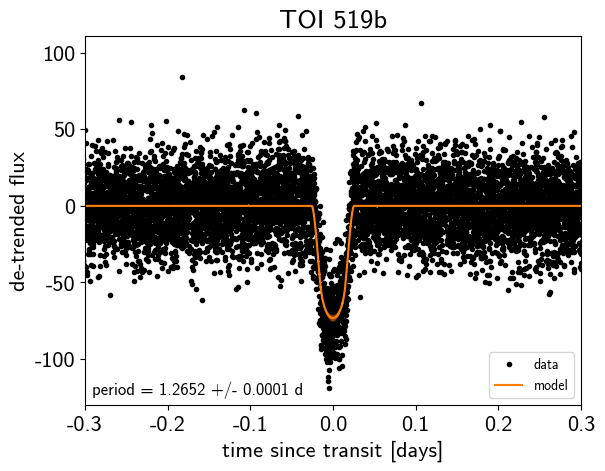

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

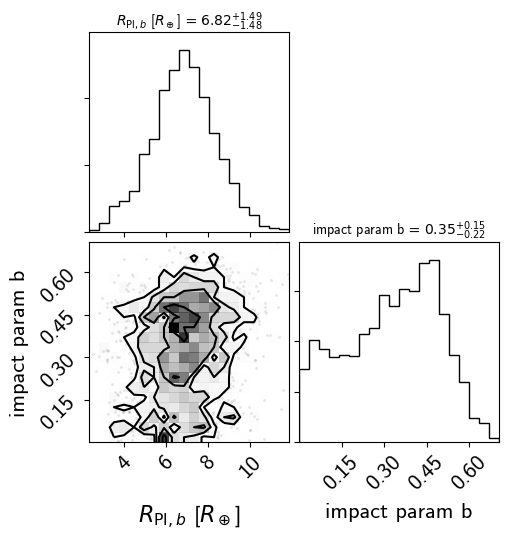

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

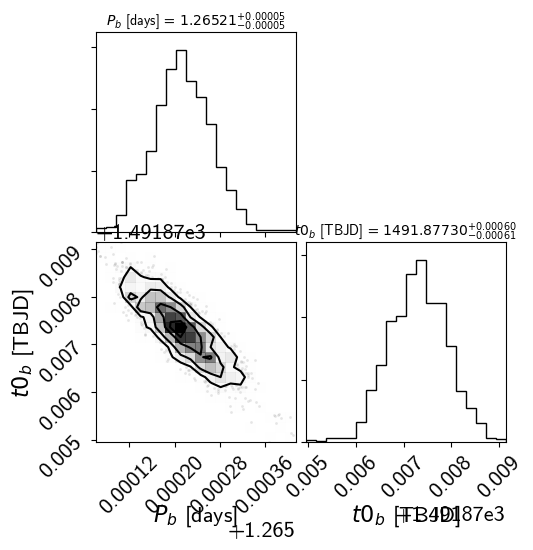

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

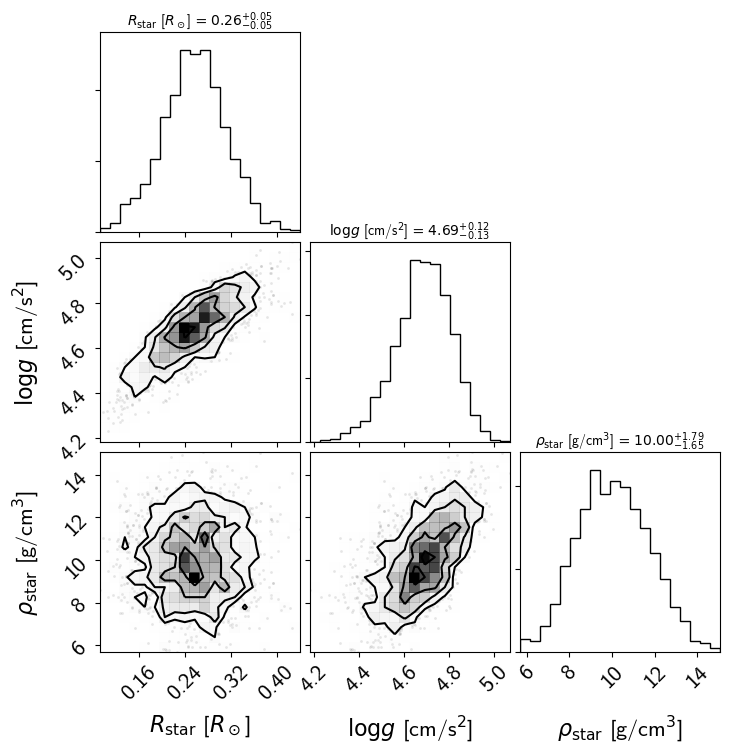

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3